# Predicting Codons using the trained Encoder model

In [1]:
import sys
import random
import numpy as np
import pandas as pd
import ast
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch import Tensor
import time
import math
import pickle as pkl

sys.path.append('../scripts')
import ml_helper
import ml_evaluation
import Classifier as Classifier
import Baseline_classifiers as bc

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
def to_pickle(obj, path):
    with open(path, 'wb') as file:
        pkl.dump(obj, file)
def from_pickle(path): 
    with open(path, 'rb') as file:
        return pkl.load(file)

### Data Preparation

In [4]:
amino_acids = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V', '*',
               '_']

aminoacids_to_integer = dict((a, i) for i, a in enumerate(amino_acids))
integer_to_aminoacids = dict((i, a) for i, a in enumerate(amino_acids))

codons = ['TTT', 'TTC', 'TTA', 'TTG', 'TCT', 'TCC', 'TCA', 'TCG', 'TAT', 'TAC', 'TAA', 'TAG', 'TGT', 'TGC', 'TGA',
          'TGG', 'CTT', 'CTC', 'CTA', 'CTG', 'CCT', 'CCC', 'CCA', 'CCG', 'CAT', 'CAC', 'CAA', 'CAG', 'CGT', 'CGC',
          'CGA', 'CGG', 'ATT', 'ATC', 'ATA', 'ATG', 'ACT', 'ACC', 'ACA', 'ACG', 'AAT', 'AAC', 'AAA', 'AAG', 'AGT',
          'AGC', 'AGA', 'AGG', 'GTT', 'GTC', 'GTA', 'GTG', 'GCT', 'GCC', 'GCA', 'GCG', 'GAT', 'GAC', 'GAA', 'GAG',
          'GGT', 'GGC', 'GGA', 'GGG', '___']

codons_to_integer = dict((c, i) for i, c in enumerate(codons))
integer_to_codons = dict((i, c) for i, c in enumerate(codons))

In [5]:
organism = "E.Coli"

def group_codons(sequence):
    return [''.join(sequence[i:i+3]) for i in range(0, len(sequence), 3)]

df = pd.read_pickle(f"../data/{organism}/cleanedData_test.pkl")
usage_biases = pd.read_pickle(f"../data/{organism}/usageBias.pkl")
df['codons'] = df['sequence'].apply(group_codons)

display(df.head())

,id,description,sequence,translation,seguid,codons
1,lcl|U00096.3_cds_AAC73113.1_2,lcl|U00096.3_cds_AAC73113.1_2 [gene=thrA] [loc...,"(A, T, G, C, G, A, G, T, G, T, T, G, A, A, G, ...","(M, R, V, L, K, F, G, G, T, S, V, A, N, A, E, ...",/p+3Jdgat4Fq0w2rqqay4xg8Bs4,"[ATG, CGA, GTG, TTG, AAG, TTC, GGC, GGT, ACA, ..."
5,lcl|U00096.3_cds_AAC73117.1_6,lcl|U00096.3_cds_AAC73117.1_6 [gene=yaaA] [loc...,"(A, T, G, C, T, G, A, T, T, C, T, T, A, T, T, ...","(M, L, I, L, I, S, P, A, K, T, L, D, Y, Q, S, ...",vJJ0yR31YORqwI12U79SgItYU3U,"[ATG, CTG, ATT, CTT, ATT, TCA, CCT, GCG, AAA, ..."
12,lcl|U00096.3_cds_AAC73124.1_13,lcl|U00096.3_cds_AAC73124.1_13 [gene=yaaI] [lo...,"(A, T, G, A, A, A, T, C, C, G, T, T, T, T, T, ...","(M, K, S, V, F, T, I, S, A, S, L, A, I, S, L, ...",GT2zzYZoFncaOMVxs4CEcLaePdc,"[ATG, AAA, TCC, GTT, TTT, ACG, ATT, TCC, GCC, ..."
17,lcl|U00096.3_cds_AAT48122.1_18,lcl|U00096.3_cds_AAT48122.1_18 [gene=hokC] [lo...,"(A, T, G, A, A, G, C, A, G, C, A, T, A, A, G, ...","(M, K, Q, H, K, A, M, I, V, A, L, I, V, I, C, ...",yfUY1Sxn8BgBfdGY1FQnaroApNY,"[ATG, AAG, CAG, CAT, AAG, GCG, ATG, ATT, GTC, ..."
23,lcl|U00096.3_cds_AAC73135.1_24,lcl|U00096.3_cds_AAC73135.1_24 [gene=yaaY] [lo...,"(A, T, G, T, G, C, C, G, G, C, A, C, T, C, G, ...","(M, C, R, H, S, L, R, S, D, G, A, G, F, Y, Q, ...",m/3aWNuEiWlqAe7cvTcnrZ58efA,"[ATG, TGC, CGG, CAC, TCG, TTA, CGT, AGT, GAT, ..."


In [6]:
min_length = None
max_length = None

df = ml_helper.filter_sequence_length(df, min_length, max_length)

In [7]:
len(df)

771

## Load trained model

In [8]:
SPEEDS_ADDED = False

In [9]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 500):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [10]:
class EncoderClassifier(nn.Module):
    def __init__(self, embed_dim, num_layers, num_heads, dropout=0.2, pos_enc=False):
        super(EncoderClassifier, self).__init__()

        emb_size = embed_dim
        if SPEEDS_ADDED:
            emb_size -= 1
        self.emb = nn.Embedding(len(amino_acids), emb_size, padding_idx=len(amino_acids)-1)
        self.pos_enc = pos_enc
        self.pos_encoder = PositionalEncoding(embed_dim, dropout)

        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(
            encoder_layer=self.encoder_layer,
            num_layers=num_layers,
        )
        self.linear = nn.Linear(embed_dim, len(codons))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.long()
        if SPEEDS_ADDED:
            x1 = self.emb(x[:, :, 0])
            x2 = x[:, :, 1].unsqueeze(-1)
            x = torch.cat((x1, x2), dim=-1)  # Concatenate along the feature dimension
        else:
            x = self.emb(x)

        if self.pos_enc:
            x = x.transpose(0, 1)
            x = self.pos_encoder(x)  # Add positional encoding
            x = x.transpose(0, 1)
        x = self.encoder(x)
        x = self.dropout(x)
        out = self.linear(x)
        return out

In [11]:
EMBED_DIM = 256
NUM_ENCODER_LAYERS = 4
NUM_HEADS = 4
DROPOUT = 0.3

model = EncoderClassifier(
    embed_dim=EMBED_DIM,
    num_layers=NUM_ENCODER_LAYERS,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    pos_enc=False
).to(device)
model = ml_helper.load_model('encoder_256em_4l_4h_03dr_10ep', organism)

Model loaded: 20240527165936_encoder_256em_4l_4h_03dr_10ep.pt


## Prepare data for max_length cutting and putting together again

In [12]:
def cut_sequence(aa_sequence, max_length):
    aa_sequences = []
    bit_map = "" # 1 if sequence is cut, 0 if not
    if aa_sequence.shape[0] <= max_length:
        aa_sequences = [aa_sequence]
        bit_map = "0"
    elif aa_sequence.shape[0] > max_length:
        aa_splits = ml_helper._split_tensor(aa_sequence, max_length)
        aa_sequences = aa_splits
        bit_map = "1" * (len(aa_splits) - 1) + "0"
    return aa_sequences, bit_map

In [13]:
def rebuild_sequences(sequences, cut_bit_map):
    new_sequences = []
    new_sequence = None
    for i, sequence in enumerate(sequences):
        if new_sequence is None:
            new_sequence = sequence
        elif new_sequence is not None:
            if type(new_sequence) == torch.Tensor:
                new_sequence = torch.cat((new_sequence, sequence))
            elif type(new_sequence) == list:
                new_sequence += sequence

        if cut_bit_map[i] == "0":
            new_sequences.append(new_sequence)
            new_sequence = None
    return new_sequences

In [14]:
def remove_padding(sequence, padding_value):
    return sequence[sequence != padding_value]

In [15]:
padding_pos = 'right'
def prepare_aa_sequence(aa_sequence):
    max_length = 500
    non_cut_aa_sequence = ml_helper.aa_to_int_tensor(aa_sequence, device)
    aa_sequences, bit_map = cut_sequence(non_cut_aa_sequence, max_length)
    for i, aa_sequence in enumerate(aa_sequences):
        aa_sequences[i] = ml_helper.pad_tensor(aa_sequence, max_length, aminoacids_to_integer['_'], padding_pos)
        if SPEEDS_ADDED:
            aa_sequences[i] = ml_helper.add_speed_dimension(aa_sequences[i], device)
    return aa_sequences, bit_map, non_cut_aa_sequence

In [16]:
# Prepare data (pad, convert to tensor)
prepared_amino_seq = []
cut_bit_map = ""
non_cut_aa_sequences = []
i = 0
for seq in df['translation']:
    aa_sequences, bit_map, non_cut_aa_sequence = prepare_aa_sequence(seq)
    prepared_amino_seq += aa_sequences
    cut_bit_map += bit_map
    non_cut_aa_sequences.append(non_cut_aa_sequence)
# create data_loader for batched throughput
batch_size = 32
data_loader = DataLoader(prepared_amino_seq, batch_size=batch_size)

In [17]:
if SPEEDS_ADDED:
    for i, aa_sequence in enumerate(prepared_amino_seq):
        prepared_amino_seq[i] = aa_sequence[:, 0].int()

In [18]:
re_sequences = rebuild_sequences(prepared_amino_seq, cut_bit_map)

In [19]:
for i, rebuild_sequence in enumerate(re_sequences):
    re_sequences[i] = remove_padding(rebuild_sequence, aminoacids_to_integer["_"])

In [20]:
def are_lists_equal(list1, list2):
    if len(list1) != len(list2):
        return False

    for tensor1, tensor2 in zip(list1, list2):
        if tensor1.shape[0] != tensor2.shape[0]:
            return False
        if not torch.allclose(tensor1, tensor2):
            return False

    return True

In [21]:
are_lists_equal(non_cut_aa_sequences, re_sequences)

True

## Testing the codon prediction

In [22]:
def predict_codons(model, aa_sequence_list):
    # Prepare data (pad, convert to tensor)
    prepared_amino_seq = []
    cut_bit_map = ""
    for seq in aa_sequence_list:
        aa_sequences, bit_map, _ = prepare_aa_sequence(seq)
        prepared_amino_seq += aa_sequences
        cut_bit_map += bit_map

    # create data_loader for batched throughput
    batch_size = 32
    data_loader = DataLoader(prepared_amino_seq, batch_size=batch_size)

    model.eval()
    codon_predictions = []
    with torch.no_grad():
        for batch in data_loader:
            output = model(batch)  # (batch_size, seq_len, num_classes)
            for batch_i in range(output.shape[0]):
                predicted_codons = []
                for seq_i in range(output.shape[1]):
                    if SPEEDS_ADDED:
                        aa_num = batch[batch_i][seq_i][0].item()
                    else:
                        aa_num = batch[batch_i][seq_i].item()
                    if aa_num == aminoacids_to_integer['_']:
                        break
                    codon_idx = torch.argmax(output[batch_i][seq_i]).item()
                    codon = integer_to_codons[codon_idx]
                    predicted_codons.append(codon)
                codon_predictions.append(predicted_codons)
    codon_predictions = rebuild_sequences(codon_predictions, cut_bit_map)
    return codon_predictions

In [23]:
amino_seq = df['translation'].head()
batched_predictions = predict_codons(model, amino_seq)

In [24]:
len(batched_predictions[0])

821

## Building the classifier

In [25]:
amino_acids_to_codons = {
    'A': ['GCT', 'GCC', 'GCA', 'GCG'],
    'R': ['CGT', 'CGC', 'CGA', 'CGG', 'AGA', 'AGG'],
    'N': ['AAT', 'AAC'],
    'D': ['GAT', 'GAC'],
    'C': ['TGT', 'TGC'],
    'Q': ['CAA', 'CAG'],
    'E': ['GAA', 'GAG'],
    'G': ['GGT', 'GGC', 'GGA', 'GGG'],
    'H': ['CAT', 'CAC'],
    'I': ['ATT', 'ATC', 'ATA'],
    'L': ['TTA', 'TTG', 'CTT', 'CTC', 'CTA', 'CTG'],
    'K': ['AAA', 'AAG'],
    'M': ['ATG'],
    'F': ['TTT', 'TTC'],
    'P': ['CCT', 'CCC', 'CCA', 'CCG'],
    'S': ['TCT', 'TCC', 'TCA', 'TCG', 'AGT', 'AGC'],
    'T': ['ACT', 'ACC', 'ACA', 'ACG'],
    'W': ['TGG'],
    'Y': ['TAT', 'TAC'],
    'V': ['GTT', 'GTC', 'GTA', 'GTG'],
    '*': ['TAA', 'TAG', 'TGA']
}

In [26]:
max_weighted_bc = bc.Max_Bias_Baseline_Classifier(usage_biases)
def check_and_replace_codons(aa_sequences, codon_predictions_list):
    total_codons = 0
    not_possible_codons = 0
    used_max_bias = 0
    for i, aa_seq in enumerate(aa_sequences):
        codon_predictions = codon_predictions_list[i]
        for j, aa in enumerate(aa_seq):
            total_codons += 1
            codon_pred = codon_predictions[j]
            max_bias_pred = max_weighted_bc._predict_codon(aa)
            if codon_pred not in amino_acids_to_codons[aa]:
                not_possible_codons += 1
                
                codon_predictions_list[i][j] = max_bias_pred
            else:
                if codon_pred == max_bias_pred:
                    used_max_bias += 1
    max_bias_ratio = used_max_bias / total_codons
    print(f"Model used max bias codon for {max_bias_ratio*100:.2f}% of possible codon predictions")
    not_possible_ratio = not_possible_codons / total_codons
    print(f"Replaced {not_possible_ratio*100:.2f}% of codons")
    return codon_predictions_list

In [27]:
class Encoder_Classifier(Classifier.Classifier):
    def __init__(self, trained_model, seed=42):
        self.model = trained_model
        super().__init__(seed)


    def predict_codons(self, aa_sequences, replace=False):
        predictions_list = predict_codons(self.model, aa_sequences)
        if replace:
            predictions_list = check_and_replace_codons(aa_sequences, predictions_list)
        predictions_matrix = self.pad_and_convert_seq(predictions_list)
        return predictions_matrix

In [28]:
EMBED_DIM = 256
NUM_ENCODER_LAYERS = 4
NUM_HEADS = 4

model = EncoderClassifier(
    embed_dim=EMBED_DIM,
    num_layers=NUM_ENCODER_LAYERS,
    num_heads=NUM_HEADS
).to(device)
model = ml_helper.load_model('encoder_256em_4l_4h_03dr_10ep', organism)

Model loaded: 20240527165936_encoder_256em_4l_4h_03dr_10ep.pt


In [29]:
%%time 
encoder_classifier = Encoder_Classifier(model)
amino_seq = df['translation']
true_codons = df['codons']
pred_codons_replaced = encoder_classifier.predict_codons(amino_seq, replace=True)

Model used max bias codon for 92.57% of possible codon predictions
Replaced 0.00% of codons
CPU times: user 7.35 s, sys: 0 ns, total: 7.35 s
Wall time: 7.35 s


In [30]:
accuracy = encoder_classifier.calc_accuracy(true_codons, pred_codons_replaced)
print(f"Organismus {organism} - Accuracy: {accuracy}")

Organismus E.Coli - Accuracy: 0.5243945001960522


### Compare with baseline classifier

In [143]:
max_weighted_bc = bc.Max_Bias_Baseline_Classifier(usage_biases)
amino_seq = df['translation'].apply(lambda seq: list(seq))
true_codons = df['codons']
pred_codons = max_weighted_bc.predict_codons(amino_seq)
accuracy = max_weighted_bc.calc_accuracy(true_codons, pred_codons)
print(f"Organismus {organism} - Accuracy: {accuracy}")

Organismus E.Coli - Accuracy: 0.5174658847557534


## Results Hyperparameter Tuning

In [29]:
def eval_parameter_model(embed_dim, num_encoder_layers, num_heads, dropout, pos_enc, num_epochs):
    start_time = time.time()

    model = EncoderClassifier(
        embed_dim=embed_dim,
        num_layers=num_encoder_layers,
        num_heads=num_heads
    ).to(device)
    try:
        model = ml_helper.load_model( f'encoder_{embed_dim}em_{num_encoder_layers}l_{num_heads}h_{str(dropout).replace(".","")}dr_{num_epochs}ep{"_posenc" if pos_enc else ""}', organism)
    except:
        print("Not found:")
        print(f'encoder_{embed_dim}em_{num_encoder_layers}l_{num_heads}h_{str(dropout).replace(".","")}dr_{num_epochs}ep{"_posenc" if pos_enc else ""}')
        return

    encoder_classifier = Encoder_Classifier(model)
    amino_seq = df['translation']
    true_codons = df['codons']
    pred_codons_replaced = encoder_classifier.predict_codons(amino_seq, replace=True)

    accuracy = round(encoder_classifier.calc_accuracy(true_codons, pred_codons_replaced), 4)
    print(f"Accuracy: {accuracy} - Organism: {organism}, Encoder Model - Parameters: {embed_dim} embedding dim, {num_encoder_layers} layers, {num_heads} heads, {num_epochs} epochs")
    print(f"Took {round(time.time() - start_time, 2)} seconds")
    print("")
    return accuracy

In [30]:
def eval_hyperparameter_training(accuracies, embed_dims, num_encoder_layers, num_heads, dropouts, pos_enc, epochs=10):
    for EMBED_DIM in embed_dims:
        for NUM_ENCODER_LAYERS in num_encoder_layers:
            for NUM_HEADS in num_heads:
                for DROPOUT in dropouts:
                    for POS_ENC in pos_enc:
                        model_name = f'encoder_{EMBED_DIM}em_{NUM_ENCODER_LAYERS}l_{NUM_HEADS}h_{str(DROPOUT).replace(".","")}dr_{epochs}ep{"_posenc" if POS_ENC else ""}'
                        if model_name not in accuracies:
                            accuracy = eval_parameter_model(EMBED_DIM, NUM_ENCODER_LAYERS, NUM_HEADS, DROPOUT, POS_ENC, epochs)
                            if accuracy is not None:
                                accuracies[model_name] = accuracy
                            else:
                                accuracies[model_name] = 0
    print("------")
    print(accuracies)
    print("------")
    print(max(accuracies.items(), key=lambda item: item[1]))
    return accuracies

### E.Coli

In [45]:
organism = "E.Coli"

def group_codons(sequence):
    return [''.join(sequence[i:i+3]) for i in range(0, len(sequence), 3)]

df = pd.read_pickle(f"../data/{organism}/cleanedData_test.pkl")
usage_biases = pd.read_pickle(f"../data/{organism}/usageBias.pkl")
df['codons'] = df['sequence'].apply(group_codons)

min_length = None
max_length = None

df = ml_helper.filter_sequence_length(df, min_length, max_length)
len(df)

771

In [46]:
accuracies = {}

#### Dropout

In [47]:
EMBED_DIM = [256]
NUM_ENCODER_LAYERS = [4]
NUM_HEADS = [4]
dropouts = [0.1, 0.2, 0.3, 0.4, 0.5]
POS_ENC = [False]
accuracies = eval_hyperparameter_training(accuracies, EMBED_DIM, NUM_ENCODER_LAYERS, NUM_HEADS, dropouts, POS_ENC)

Model loaded: 20240527163942_encoder_256em_4l_4h_01dr_10ep.pt
Model used max bias codon for 91.08% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.5229 - Organism: E.Coli, Encoder Model - Parameters: 256 embedding dim, 4 layers, 4 heads, 10 epochs
Took 7.75 seconds

Model loaded: 20240527164018_encoder_256em_4l_4h_02dr_10ep.pt
Model used max bias codon for 92.80% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.524 - Organism: E.Coli, Encoder Model - Parameters: 256 embedding dim, 4 layers, 4 heads, 10 epochs
Took 7.5 seconds

Model loaded: 20240527165936_encoder_256em_4l_4h_03dr_10ep.pt
Model used max bias codon for 92.57% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.5244 - Organism: E.Coli, Encoder Model - Parameters: 256 embedding dim, 4 layers, 4 heads, 10 epochs
Took 7.6 seconds

Model loaded: 20240527164129_encoder_256em_4l_4h_04dr_10ep.pt
Model used max bias codon for 92.65% of possible codon predictions
Replaced 0.00% o

#### Positional Encoding

In [48]:
EMBED_DIM = [256]
NUM_ENCODER_LAYERS = [4]
NUM_HEADS = [4]
DROPOUTS = [0.3]
pos_enc = [True, False]
accuracies = eval_hyperparameter_training(accuracies, EMBED_DIM, NUM_ENCODER_LAYERS, NUM_HEADS, DROPOUTS, pos_enc)

Model loaded: 20240527164446_encoder_256em_4l_4h_03dr_10ep_posenc.pt
Model used max bias codon for 90.09% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.5224 - Organism: E.Coli, Encoder Model - Parameters: 256 embedding dim, 4 layers, 4 heads, 10 epochs
Took 7.4 seconds

------
{'encoder_256em_4l_4h_01dr_10ep': 0.5229, 'encoder_256em_4l_4h_02dr_10ep': 0.524, 'encoder_256em_4l_4h_03dr_10ep': 0.5244, 'encoder_256em_4l_4h_04dr_10ep': 0.5239, 'encoder_256em_4l_4h_05dr_10ep': 0.5218, 'encoder_256em_4l_4h_03dr_10ep_posenc': 0.5224}
------
('encoder_256em_4l_4h_03dr_10ep', 0.5244)


#### Embedding Dimension

In [49]:
embed_dims = [32, 64, 128, 256, 512, 1028]
NUM_ENCODER_LAYERS = [4]
NUM_HEADS = [4]
DROPOUTS = [0.3]
POS_ENC = [False]
accuracies = eval_hyperparameter_training(accuracies, embed_dims, NUM_ENCODER_LAYERS, NUM_HEADS, DROPOUTS, POS_ENC)

Model loaded: 20240527164954_encoder_32em_4l_4h_03dr_10ep.pt


Model used max bias codon for 100.00% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.5175 - Organism: E.Coli, Encoder Model - Parameters: 32 embedding dim, 4 layers, 4 heads, 10 epochs
Took 7.26 seconds

Model loaded: 20240527165018_encoder_64em_4l_4h_03dr_10ep.pt
Model used max bias codon for 91.50% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.5227 - Organism: E.Coli, Encoder Model - Parameters: 64 embedding dim, 4 layers, 4 heads, 10 epochs
Took 7.29 seconds

Model loaded: 20240527165045_encoder_128em_4l_4h_03dr_10ep.pt
Model used max bias codon for 94.72% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.5233 - Organism: E.Coli, Encoder Model - Parameters: 128 embedding dim, 4 layers, 4 heads, 10 epochs
Took 7.33 seconds

Model loaded: 20240527165241_encoder_512em_4l_4h_03dr_10ep.pt
Model used max bias codon for 93.21% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.5213 - Organism: E.Coli, Encoder Model -

#### Number Encoder Layers and Heads

In [50]:
EMBED_DIM = [256]
num_encoder_layers = [2, 4, 8, 16]
num_heads = [2, 4, 8, 16]
DROPOUTS = [0.3]
POS_ENC = [False]
accuracies = eval_hyperparameter_training(accuracies, EMBED_DIM, num_encoder_layers, num_heads, DROPOUTS, POS_ENC)

Model loaded: 20240527165710_encoder_256em_2l_2h_03dr_10ep.pt
Model used max bias codon for 90.48% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.5228 - Organism: E.Coli, Encoder Model - Parameters: 256 embedding dim, 2 layers, 2 heads, 10 epochs
Took 7.24 seconds

Model loaded: 20240527165729_encoder_256em_2l_4h_03dr_10ep.pt
Model used max bias codon for 91.66% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.5241 - Organism: E.Coli, Encoder Model - Parameters: 256 embedding dim, 2 layers, 4 heads, 10 epochs
Took 7.2 seconds

Model loaded: 20240527165750_encoder_256em_2l_8h_03dr_10ep.pt
Model used max bias codon for 92.38% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.5238 - Organism: E.Coli, Encoder Model - Parameters: 256 embedding dim, 2 layers, 8 heads, 10 epochs
Took 7.25 seconds

Model loaded: 20240527165817_encoder_256em_2l_16h_03dr_10ep.pt
Model used max bias codon for 91.50% of possible codon predictions
Replaced 0.00

#### Save E.Coli accuracies

In [51]:
to_pickle(accuracies, f"../data/{organism}/encoder_accuracies.pkl")

In [52]:
accuracies = from_pickle(f"../data/{organism}/encoder_accuracies.pkl")

In [53]:
accuracies

{'encoder_256em_4l_4h_01dr_10ep': 0.5229,
 'encoder_256em_4l_4h_02dr_10ep': 0.524,
 'encoder_256em_4l_4h_03dr_10ep': 0.5244,
 'encoder_256em_4l_4h_04dr_10ep': 0.5239,
 'encoder_256em_4l_4h_05dr_10ep': 0.5218,
 'encoder_256em_4l_4h_03dr_10ep_posenc': 0.5224,
 'encoder_32em_4l_4h_03dr_10ep': 0.5175,
 'encoder_64em_4l_4h_03dr_10ep': 0.5227,
 'encoder_128em_4l_4h_03dr_10ep': 0.5233,
 'encoder_512em_4l_4h_03dr_10ep': 0.5213,
 'encoder_1028em_4l_4h_03dr_10ep': 0,
 'encoder_256em_2l_2h_03dr_10ep': 0.5228,
 'encoder_256em_2l_4h_03dr_10ep': 0.5241,
 'encoder_256em_2l_8h_03dr_10ep': 0.5238,
 'encoder_256em_2l_16h_03dr_10ep': 0.5238,
 'encoder_256em_4l_2h_03dr_10ep': 0.5174,
 'encoder_256em_4l_8h_03dr_10ep': 0.5241,
 'encoder_256em_4l_16h_03dr_10ep': 0.5235,
 'encoder_256em_8l_2h_03dr_10ep': 0,
 'encoder_256em_8l_4h_03dr_10ep': 0,
 'encoder_256em_8l_8h_03dr_10ep': 0,
 'encoder_256em_8l_16h_03dr_10ep': 0,
 'encoder_256em_16l_2h_03dr_10ep': 0,
 'encoder_256em_16l_4h_03dr_10ep': 0,
 'encoder_256em_1

--> Not suited parameters: 8/16 layers, 1028 embedding size

--> Best suited parameters: encoder_256em_4l_4h_03dr_10ep - Accuracy: 0.5244

#### Baseline Classifier

In [55]:
max_weighted_bc = bc.Max_Bias_Baseline_Classifier(usage_biases)
amino_seq = df['translation'].apply(lambda seq: list(seq))
true_codons = df['codons']
pred_codons_bc = max_weighted_bc.predict_codons(amino_seq)
accuracy = max_weighted_bc.calc_accuracy(true_codons, pred_codons_bc)
accuracy = round(accuracy, 4)
print(f"Organismus {organism} - Accuracy: {accuracy}")

Organismus E.Coli - Accuracy: 0.5175


### Drosophila.Melanogaster

In [56]:
organism = "Drosophila.Melanogaster"

def group_codons(sequence):
    return [''.join(sequence[i:i+3]) for i in range(0, len(sequence), 3)]

df = pd.read_pickle(f"../data/{organism}/cleanedData_test.pkl")
usage_biases = pd.read_pickle(f"../data/{organism}/usageBias.pkl")
df['codons'] = df['sequence'].apply(group_codons)

min_length = None
max_length = None

df = ml_helper.filter_sequence_length(df, min_length, max_length)
len(df)

4335

In [35]:
accuracies = {}

In [59]:
embed_dims = [256, 512]
num_encoder_layers = [4, 8]
num_heads = [4, 8]
DROPOUTS = [0.3]
POS_ENC = [False]
accuracies = eval_hyperparameter_training(accuracies, embed_dims, num_encoder_layers, num_heads, DROPOUTS, POS_ENC)

Model loaded: 20240527173508_encoder_256em_4l_4h_03dr_10ep.pt
Model used max bias codon for 88.39% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.4074 - Organism: Drosophila.Melanogaster, Encoder Model - Parameters: 256 embedding dim, 4 layers, 4 heads, 10 epochs
Took 107.01 seconds

Model loaded: 20240527173549_encoder_256em_4l_8h_03dr_10ep.pt
Model used max bias codon for 87.68% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.4099 - Organism: Drosophila.Melanogaster, Encoder Model - Parameters: 256 embedding dim, 4 layers, 8 heads, 10 epochs
Took 107.06 seconds

Not found:
encoder_256em_8l_4h_03dr_10ep
Not found:
encoder_256em_8l_8h_03dr_10ep
Model loaded: 20240527173927_encoder_512em_4l_4h_03dr_10ep.pt
Model used max bias codon for 88.43% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.4102 - Organism: Drosophila.Melanogaster, Encoder Model - Parameters: 512 embedding dim, 4 layers, 4 heads, 10 epochs
Took 108.48 seconds

Mod

#### Save Drosophila.Melanogaster accuracies

In [60]:
to_pickle(accuracies, f"../data/{organism}/encoder_accuracies.pkl")

In [61]:
accuracies = from_pickle(f"../data/{organism}/encoder_accuracies.pkl")

In [62]:
accuracies

{'encoder_256em_4l_4h_03dr_10ep': 0.4074,
 'encoder_256em_4l_8h_03dr_10ep': 0.4099,
 'encoder_256em_8l_4h_03dr_10ep': 0,
 'encoder_256em_8l_8h_03dr_10ep': 0,
 'encoder_512em_4l_4h_03dr_10ep': 0.4102,
 'encoder_512em_4l_8h_03dr_10ep': 0.3968,
 'encoder_512em_8l_4h_03dr_10ep': 0,
 'encoder_512em_8l_8h_03dr_10ep': 0}

--> Not suited parameters: 8 layers

--> Best suited parameters: encoder_512em_4l_4h_03dr_10ep - Accuracy: 0.4102

#### Baseline Classifier

In [63]:
max_weighted_bc = bc.Max_Bias_Baseline_Classifier(usage_biases)
amino_seq = df['translation'].apply(lambda seq: list(seq))
true_codons = df['codons']
pred_codons_bc = max_weighted_bc.predict_codons(amino_seq)
accuracy = max_weighted_bc.calc_accuracy(true_codons, pred_codons_bc)
accuracy = round(accuracy, 4)
print(f"Organismus {organism} - Accuracy: {accuracy}")

Organismus Drosophila.Melanogaster - Accuracy: 0.492


### Homo.Sapiens

In [31]:
organism = "Homo.Sapiens"

def group_codons(sequence):
    return [''.join(sequence[i:i+3]) for i in range(0, len(sequence), 3)]

df = pd.read_pickle(f"../data/{organism}/cleanedData_test.pkl")
usage_biases = pd.read_pickle(f"../data/{organism}/usageBias.pkl")
df['codons'] = df['sequence'].apply(group_codons)
df = ml_helper.remove_x_rows(df)

min_length = None
max_length = None

df = ml_helper.filter_sequence_length(df, min_length, max_length)
len(df)

18278

In [36]:
accuracies = {}

In [37]:
embed_dims = [256, 512]
num_encoder_layers = [4, 6]
num_heads = [4, 8]
DROPOUTS = [0.3]
POS_ENC = [False]
accuracies = eval_hyperparameter_training(accuracies, embed_dims, num_encoder_layers, num_heads, DROPOUTS, POS_ENC)

Model loaded: 20240527185016_encoder_256em_4l_4h_03dr_10ep.pt
Model used max bias codon for 89.91% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.3856 - Organism: Homo.Sapiens, Encoder Model - Parameters: 256 embedding dim, 4 layers, 4 heads, 10 epochs
Took 542.47 seconds

Model loaded: 20240527185057_encoder_256em_4l_8h_03dr_10ep.pt
Model used max bias codon for 89.40% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.3885 - Organism: Homo.Sapiens, Encoder Model - Parameters: 256 embedding dim, 4 layers, 8 heads, 10 epochs
Took 539.08 seconds

Not found:
encoder_256em_6l_4h_03dr_10ep
Not found:
encoder_256em_6l_8h_03dr_10ep
Model loaded: 20240527185357_encoder_512em_4l_4h_03dr_10ep.pt
Model used max bias codon for 90.85% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.3896 - Organism: Homo.Sapiens, Encoder Model - Parameters: 512 embedding dim, 4 layers, 4 heads, 10 epochs
Took 545.93 seconds

Model loaded: 20240527185504_encoder

#### Save Homo.Sapiens accuracies

In [38]:
to_pickle(accuracies, f"../data/{organism}/encoder_accuracies.pkl")

In [39]:
accuracies = from_pickle(f"../data/{organism}/encoder_accuracies.pkl")

In [40]:
accuracies

{'encoder_256em_4l_4h_03dr_10ep': 0.3856,
 'encoder_256em_4l_8h_03dr_10ep': 0.3885,
 'encoder_256em_6l_4h_03dr_10ep': 0,
 'encoder_256em_6l_8h_03dr_10ep': 0,
 'encoder_512em_4l_4h_03dr_10ep': 0.3896,
 'encoder_512em_4l_8h_03dr_10ep': 0.3915,
 'encoder_512em_6l_4h_03dr_10ep': 0,
 'encoder_512em_6l_8h_03dr_10ep': 0}

--> Not suited parameters: 6 layers

--> Best suited parameters: encoder_512em_4l_8h_03dr_10ep - Accuracy: 0.3915

#### Baseline Classifier

In [41]:
max_weighted_bc = bc.Max_Bias_Baseline_Classifier(usage_biases)
amino_seq = df['translation'].apply(lambda seq: list(seq))
true_codons = df['codons']
pred_codons_bc = max_weighted_bc.predict_codons(amino_seq)
accuracy = max_weighted_bc.calc_accuracy(true_codons, pred_codons_bc)
accuracy = round(accuracy, 4)
print(f"Organismus {organism} - Accuracy: {accuracy}")

Organismus Homo.Sapiens - Accuracy: 0.436


# Visualisation

## E.Coli

In [28]:
organism = "E.Coli"

def group_codons(sequence):
    return [''.join(sequence[i:i+3]) for i in range(0, len(sequence), 3)]

df = pd.read_pickle(f"../data/{organism}/cleanedData_test.pkl")
usage_biases = pd.read_pickle(f"../data/{organism}/usageBias.pkl")
df['codons'] = df['sequence'].apply(group_codons)

min_length = None
max_length = None

df = ml_helper.filter_sequence_length(df, min_length, max_length)
len(df)

771

In [29]:
EMBED_DIM = 256
NUM_ENCODER_LAYERS = 4
NUM_HEADS = 4
DROPOUT = 0.3
POS_ENC = False
NUM_EPOCHS = 10

model = EncoderClassifier(
    embed_dim=EMBED_DIM,
    num_layers=NUM_ENCODER_LAYERS,
    num_heads=NUM_HEADS
).to(device)
model = ml_helper.load_model( f'encoder_{EMBED_DIM}em_{NUM_ENCODER_LAYERS}l_{NUM_HEADS}h_{str(DROPOUT).replace(".","")}dr_{NUM_EPOCHS}ep{"_posenc" if POS_ENC else ""}', organism)

encoder_classifier = Encoder_Classifier(model)
amino_seq = df['translation']
true_codons = df['codons']
pred_codons_replaced = encoder_classifier.predict_codons(amino_seq, replace=True)

accuracy = round(encoder_classifier.calc_accuracy(true_codons, pred_codons_replaced), 4)
print(f"Accuracy: {accuracy}")

Model loaded: 20240527165936_encoder_256em_4l_4h_03dr_10ep.pt
Model used max bias codon for 92.57% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.5244


In [30]:
# Remove Padding
predictions = []
for codon_seq in pred_codons_replaced:
    predictions.append([codon for codon in codon_seq if codon != ''])

In [31]:
predicted, labels = ml_evaluation.flatten_for_plotting(predictions, true_codons, filter_pads=False)

In [32]:
# Translate to integers
predicted_int = []
for codon in predicted:
    predicted_int.append(ml_helper.codons_to_integer[codon])

labels_int = []
for codon in labels:
    labels_int.append(ml_helper.codons_to_integer[codon])

In [33]:
# Calculate Accuracy again to see if something changed
predicted_int_np = np.array(predicted_int)
labels_int_np = np.array(labels_int)
accuracy = np.sum(predicted_int_np == labels_int_np) / labels_int_np.size
accuracy

0.5243945001960523

In [34]:
ml_evaluation.get_unique_pred_classes(predicted, labels)

predicted different classes:  43 out of: 64
predicted following classes:  {'ACG', 'ATT', 'GGC', 'GGT', 'CAC', 'GAA', 'AAC', 'CCA', 'ACC', 'TGC', 'TAA', 'CAT', 'GTT', 'GAC', 'GCT', 'ATC', 'TTC', 'CGC', 'TAC', 'TTT', 'AGA', 'TGA', 'TGT', 'GCG', 'AAA', 'AGC', 'AGT', 'GTG', 'GAT', 'CCG', 'GCC', 'CAA', 'AAT', 'TTA', 'ATG', 'TAT', 'TGG', 'ACA', 'CAG', 'CGT', 'GGA', 'CTG', 'TCT'}


({'AAA',
  'AAC',
  'AAT',
  'ACA',
  'ACC',
  'ACG',
  'AGA',
  'AGC',
  'AGT',
  'ATC',
  'ATG',
  'ATT',
  'CAA',
  'CAC',
  'CAG',
  'CAT',
  'CCA',
  'CCG',
  'CGC',
  'CGT',
  'CTG',
  'GAA',
  'GAC',
  'GAT',
  'GCC',
  'GCG',
  'GCT',
  'GGA',
  'GGC',
  'GGT',
  'GTG',
  'GTT',
  'TAA',
  'TAC',
  'TAT',
  'TCT',
  'TGA',
  'TGC',
  'TGG',
  'TGT',
  'TTA',
  'TTC',
  'TTT'},
 {'AAA',
  'AAC',
  'AAG',
  'AAT',
  'ACA',
  'ACC',
  'ACG',
  'ACT',
  'AGA',
  'AGC',
  'AGG',
  'AGT',
  'ATA',
  'ATC',
  'ATG',
  'ATT',
  'CAA',
  'CAC',
  'CAG',
  'CAT',
  'CCA',
  'CCC',
  'CCG',
  'CCT',
  'CGA',
  'CGC',
  'CGG',
  'CGT',
  'CTA',
  'CTC',
  'CTG',
  'CTT',
  'GAA',
  'GAC',
  'GAG',
  'GAT',
  'GCA',
  'GCC',
  'GCG',
  'GCT',
  'GGA',
  'GGC',
  'GGG',
  'GGT',
  'GTA',
  'GTC',
  'GTG',
  'GTT',
  'TAA',
  'TAC',
  'TAG',
  'TAT',
  'TCA',
  'TCC',
  'TCG',
  'TCT',
  'TGA',
  'TGC',
  'TGG',
  'TGT',
  'TTA',
  'TTC',
  'TTG',
  'TTT'})

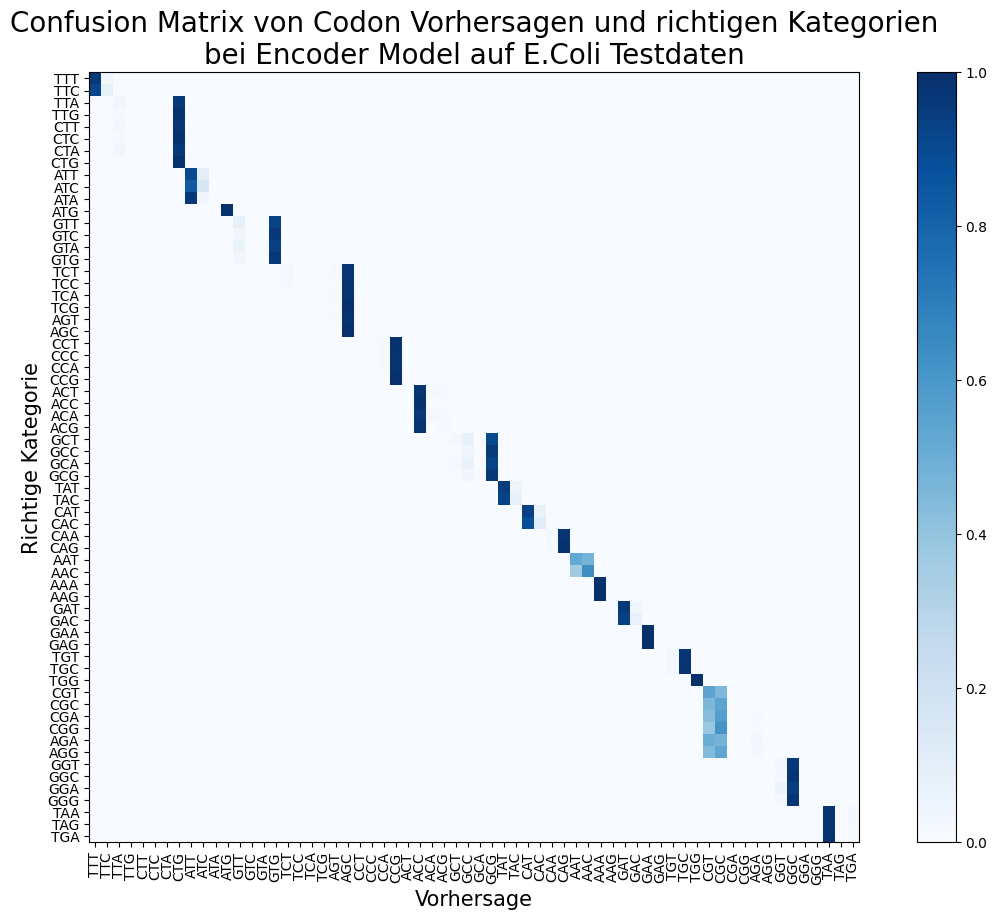

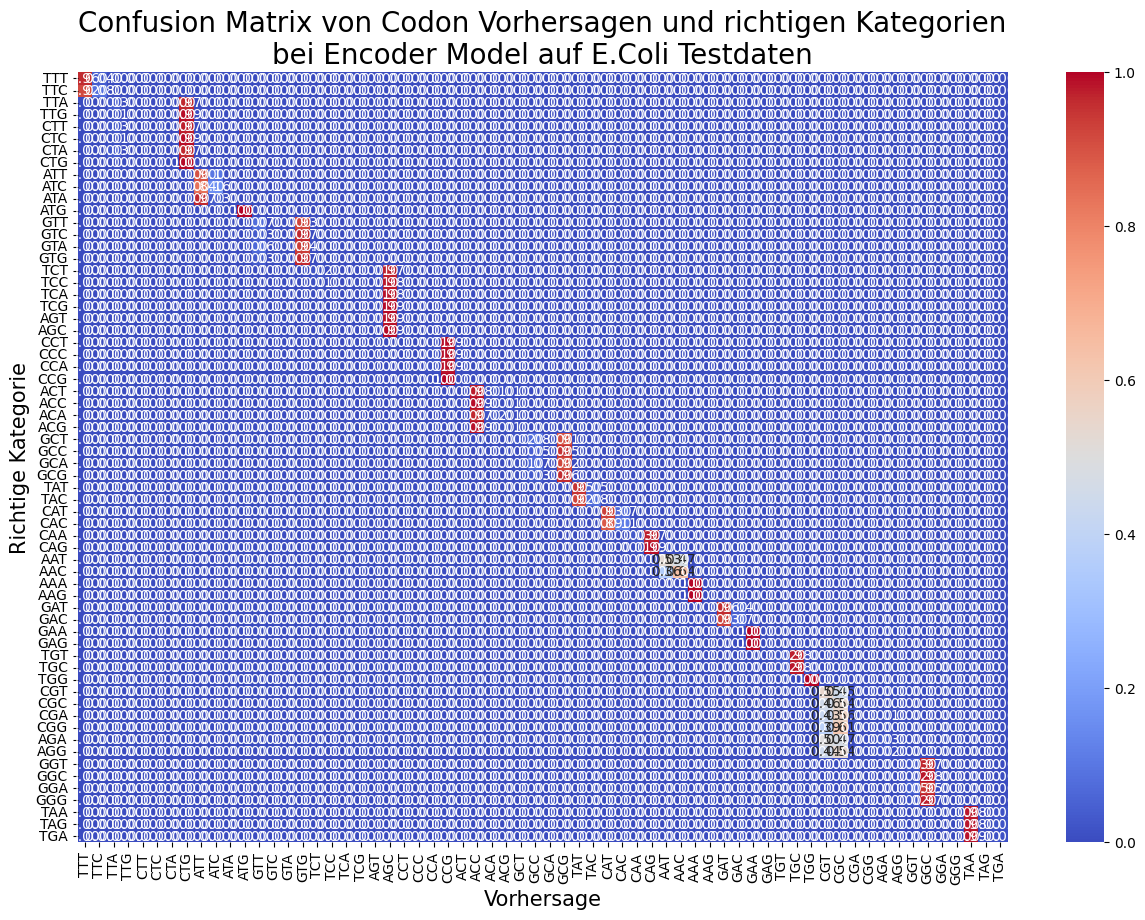

In [36]:
title = 'Confusion Matrix von Codon Vorhersagen und richtigen Kategorien\nbei Encoder Model auf E.Coli Testdaten'

plt = ml_evaluation.plot_confusion_matrix(labels_int, predicted_int, ml_helper.codons, title, sort_codons=True)
plt.show()
plt = ml_evaluation.plot_confusion_matrix_sns(labels_int, predicted_int, ml_helper.codons, title, sort_codons=True)
plt.show()

In [36]:
predicted_aa =  ml_evaluation.translate_codons(predicted)
labels_aa =  ml_evaluation.translate_codons(labels)

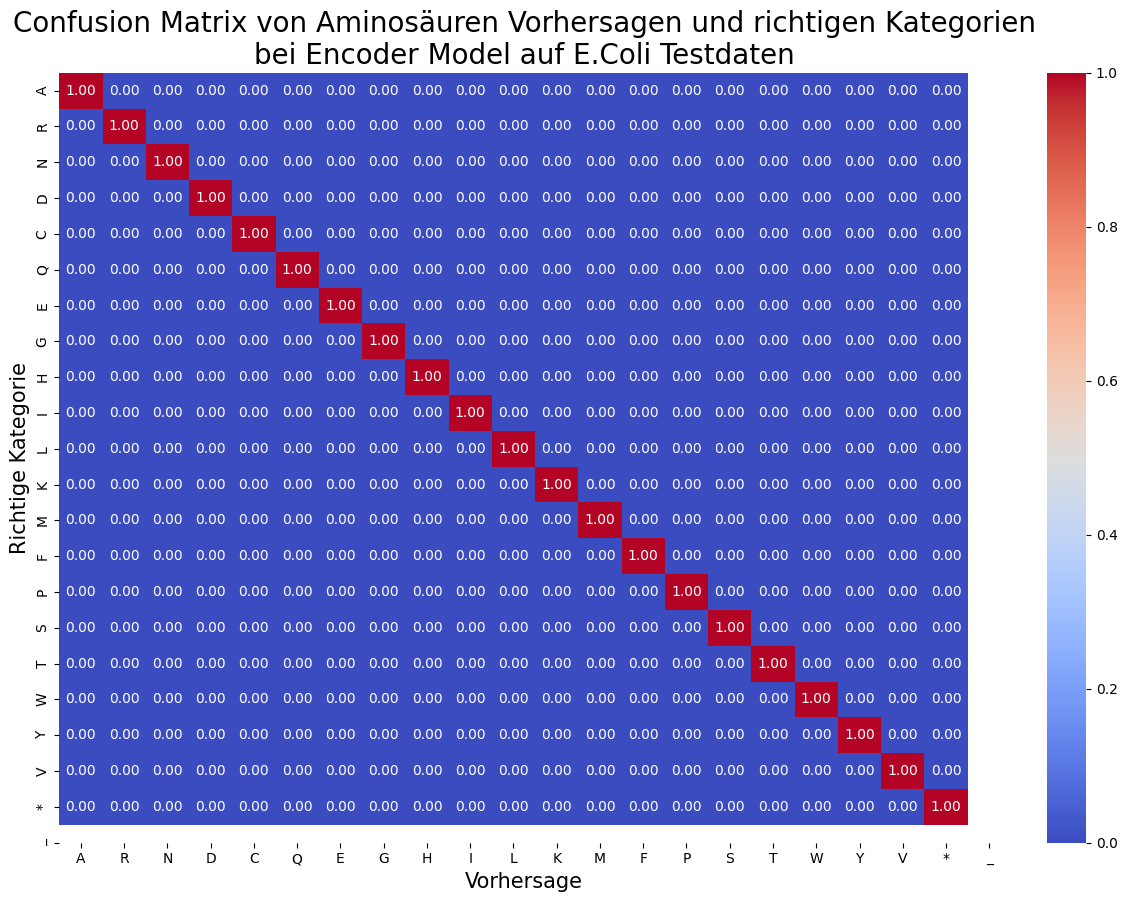

In [37]:
# Calculate confusion matrix for amino acids

plt = ml_evaluation.plot_confusion_matrix_sns(labels_aa, predicted_aa, ml_helper.amino_acids, 
                                        'Confusion Matrix von Aminosäuren Vorhersagen und richtigen Kategorien\nbei Encoder Model auf E.Coli Testdaten')
plt.show()

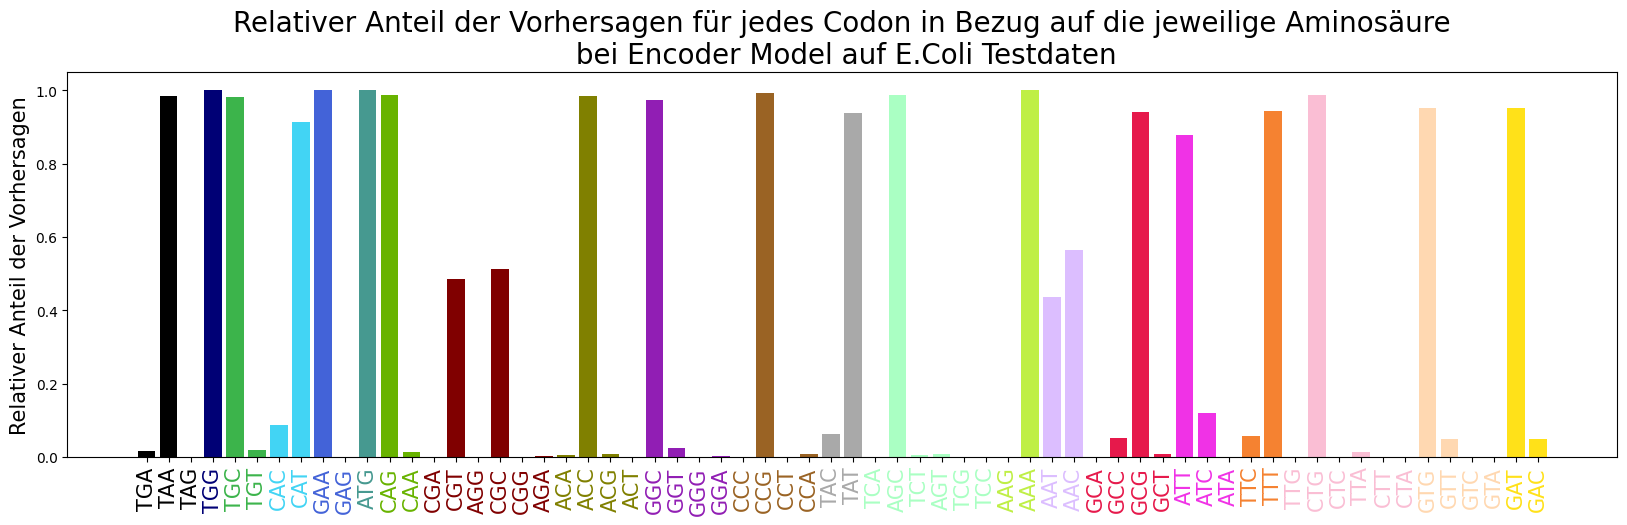

In [35]:
codon_counted_predicted = ml_evaluation.codon_count(predicted_int, labels)

plt = ml_evaluation.plot_relative_codon_count(codon_counted_predicted, predicted_int, 'Relativer Anteil der Vorhersagen für jedes Codon in Bezug auf die jeweilige Aminosäure\n bei Encoder Model auf E.Coli Testdaten')

{'ATG': 6673, 'CGA': 0, 'GTG': 5799, 'TTG': 0, 'AAG': 0, 'TTC': 325, 'GGC': 6714, 'GGT': 168, 'ACA': 30, 'TCA': 0, 'GCA': 0, 'AAT': 2160, 'GAA': 9204, 'CGT': 2646, 'TTT': 4949, 'CTG': 12297, 'GTT': 323, 'GCC': 277, 'GAT': 7126, 'ATT': 6541, 'AGC': 3632, 'AGG': 0, 'CAG': 6595, 'GGG': 0, 'ACC': 5463, 'GTC': 0, 'CTC': 0, 'TCT': 32, 'CCC': 0, 'AAA': 8081, 'ATC': 955, 'AAC': 3239, 'CAC': 262, 'GCG': 7369, 'GCT': 71, 'TTA': 107, 'CTT': 0, 'ACG': 25, 'GGA': 9, 'CCG': 5338, 'CAA': 93, 'ACT': 0, 'ATA': 0, 'CAT': 2836, 'AGT': 23, 'TGC': 1468, 'GAG': 0, 'TCG': 0, 'GTA': 0, 'CGC': 2630, 'TAC': 219, 'TCC': 0, 'GAC': 297, 'TGT': 28, 'TGG': 3556, 'TAT': 3622, 'CCT': 0, 'CCA': 28, 'CGG': 0, 'CTA': 0, 'TGA': 3, 'TAA': 477, 'AGA': 12, 'TAG': 0}


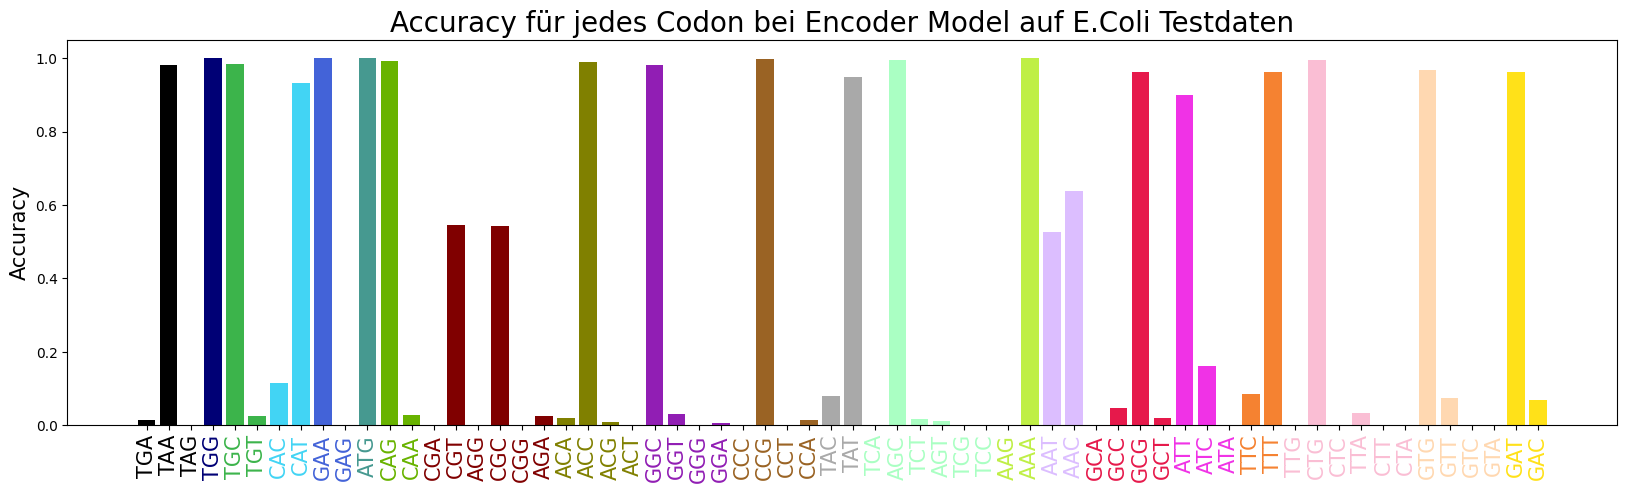

In [36]:
plt = ml_evaluation.plot_codon_acc(labels_int, predicted_int, 'Accuracy für jedes Codon bei Encoder Model auf E.Coli Testdaten')

In [37]:
usage_biases_codons = {}
codon_to_aa = ml_evaluation.dict_aa_codon()
for codon in labels:
    aa = codon_to_aa[codon]
    usage_biases_codons[codon] = usage_biases[aa][codon]

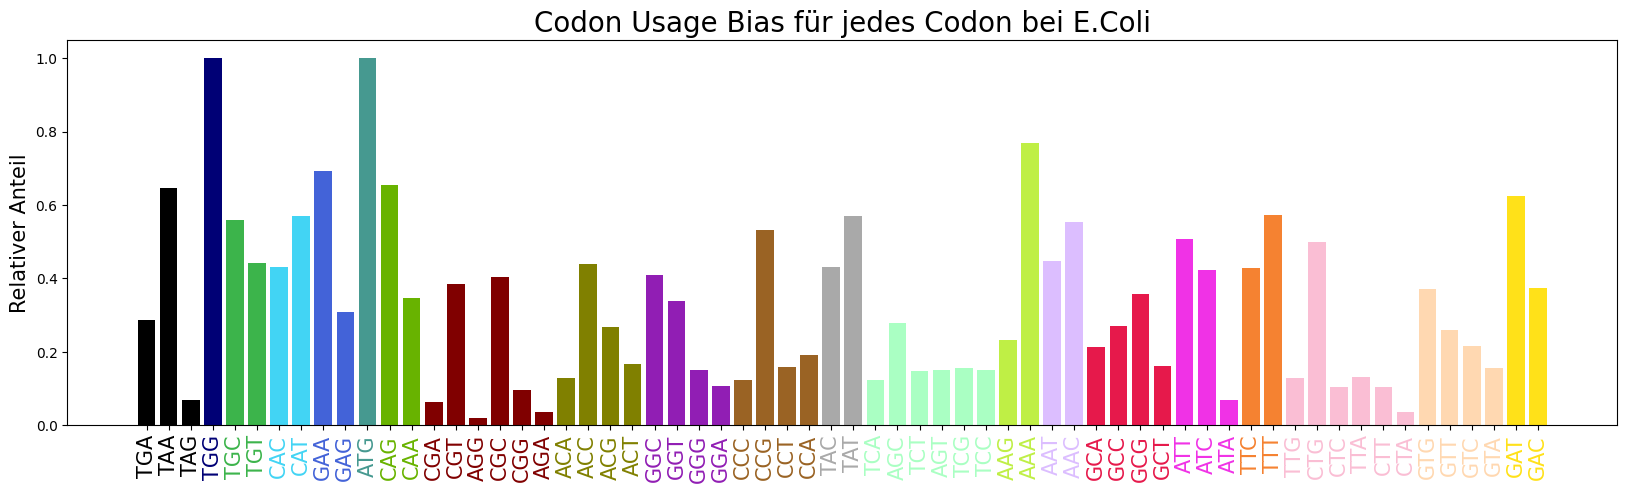

In [38]:
plt = ml_evaluation.plot_cub(usage_biases_codons, "Codon Usage Bias für jedes Codon bei E.Coli")

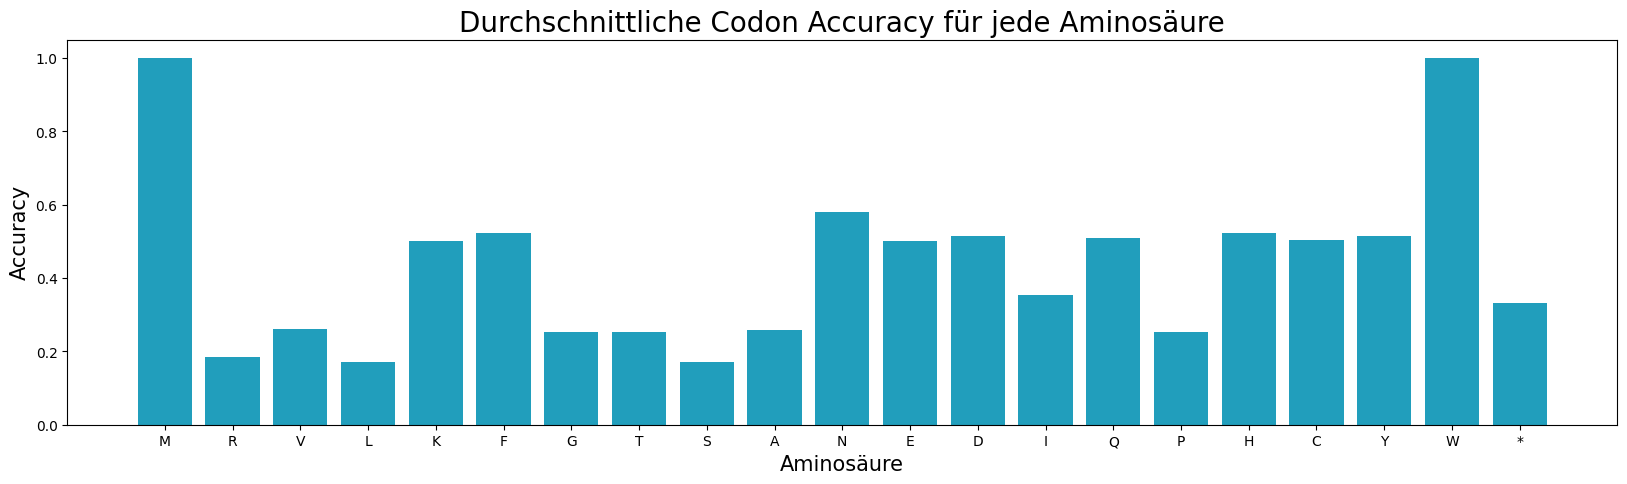

In [39]:
ml_evaluation.plot_avg_aa_acc(labels_int, predicted_int).show()

## Comparison of all Baselines and  best Encoder models for all Organisms

In [40]:
results = {
    "E.Coli": {
        "Max CUB": 0.5175,
        "Transformer": 0.5244
    },
    "Fruchtfliege": {
        "Max CUB": 0.492,
        "Transformer": 0.4102
    },
    "Mensch": {
        "Max CUB": 0.436,
        "Transformer": 0.3915
    }
}

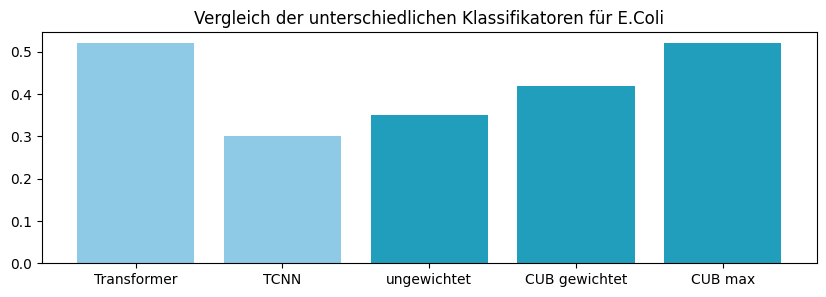

In [41]:
# Accuracy for basilines unweighted, weighted, max, tcnn validation, tcnn training
accuracies = [0.52, 0.30, 0.35, 0.42, 0.52]
labels = ['Transformer', 'TCNN', 'ungewichtet', 'CUB gewichtet', 'CUB max']

import matplotlib.pyplot as plt
# Define colors for each group
colors = ['#8ecae6', '#8ecae6', '#219ebc', '#219ebc', '#219ebc']

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 3))
ax.bar(labels, accuracies, color=colors)
plt.title('Vergleich der unterschiedlichen Klassifikatoren für E.Coli')
plt.show()

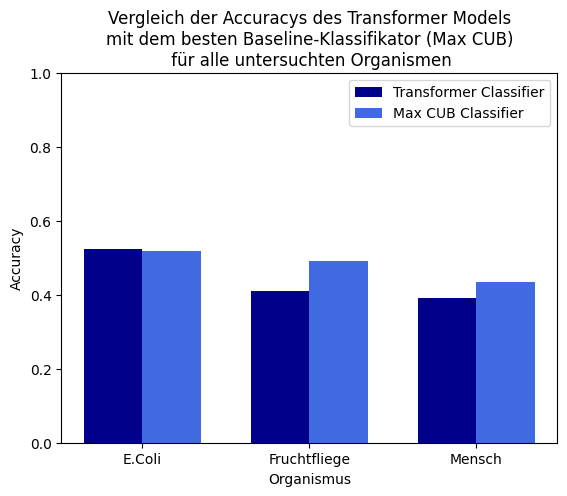

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Data
results = {
    "E.Coli": {
        "Max CUB": 0.5175,
        "Transformer": 0.5244
    },
    "Fruchtfliege": {
        "Max CUB": 0.492,
        "Transformer": 0.4102
    },
    "Mensch": {
        "Max CUB": 0.436,
        "Transformer": 0.3915
    }
}

# Prepare data for plotting
organisms = list(results.keys())
max_cub_values = [results[org]["Max CUB"] for org in organisms]
transformer_values = [results[org]["Transformer"] for org in organisms]

# Number of bars
x = np.arange(len(organisms))

# Bar width
width = 0.35

# Create the plot
fig, ax = plt.subplots()

# Plotting the bars
bars1 = ax.bar(x - width/2, transformer_values, width, label='Transformer Classifier', color='darkblue')
bars2 = ax.bar(x + width/2, max_cub_values, width, label='Max CUB Classifier', color='#4169e1')


# Adding labels and title
ax.set_xlabel('Organismus')
ax.set_ylabel('Accuracy')
ax.set_title('Vergleich der Accuracys des Transformer Models\nmit dem besten Baseline-Klassifikator (Max CUB)\n für alle untersuchten Organismen')
ax.set_xticks(x)
ax.set_xticklabels(organisms)
ax.set_ylim(0, 1)
ax.legend()

# Display the plot
plt.show()
